In [1]:
import numpy as np

In [2]:
import arctan2 as myF

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def step(rpos, odm, noise = None):
    v = odm[0]
    r = odm[1]
    if noise is not None:
        v += np.random.normal(0, noise[0])
        r += np.random.normal(0, noise[1])
    x = rpos[0] + v * np.cos(rpos[2])
    y = rpos[1] + v * np.sin(rpos[2])
    t = rpos[2] + r
    return np.array([x, y, t], np.float32)

In [5]:
def observation(rpos, lm, noise = None):
    d = lm[:] - rpos[:2]
    length = np.linalg.norm(d, axis=1)
    t = np.arctan2(d[:,1], d[:,0]) - rpos[2]
    
    if noise is not None:
        length += np.random.normal(0, noise[0], length.shape)
        t += np.random.normal(0, noise[1], t.shape)
        
    obs = np.stack((length, t), axis=1)
    return obs

In [6]:
noise_odm=None
noise_obs=None
noise_odm = [0.01, 0.01]
noise_obs = [0.03, 0.03]

landmark = (np.random.rand(100, 2) - 0.5) / 1.5

rpos = np.array([0, -0.2, 0], np.float32)
obs = observation(rpos, landmark, noise_obs)
log = [(rpos, None, None)]

for i in range(100):
    odm = np.array([0.1, 0.5])
    rpos = step(rpos, odm, noise_odm)
    obs = observation(rpos, landmark, noise_obs)
    log.append((rpos, odm, obs))

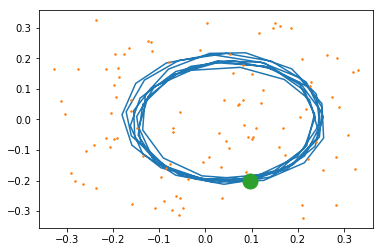

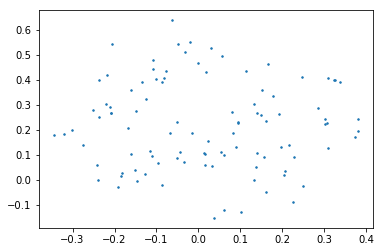

In [7]:
idx = 1
pts = np.array([rpos for rpos, odm, obs in log])[:,:2]
plt.plot(pts[:,0],pts[:,1], linestyle='-')
plt.plot(landmark[:,0], landmark[:,1], linestyle='None', marker='.', markersize=3)
plt.plot(pts[idx,0],pts[idx,1], linestyle='None', marker='.', markersize=30)

plt.show()

x = log[idx][2][:,0] * np.cos(log[idx][2][:,1])
y = log[idx][2][:,0] * np.sin(log[idx][2][:,1])
plt.plot(x, y, linestyle='None', marker='.', markersize=3)
plt.show()

In [8]:
def mapping(rpos, obs):
    dx = obs[:,0] * np.cos(obs[:,1])
    dy = obs[:,0] * np.sin(obs[:,1])
    x, y, t = rpos
    r = np.array([[np.cos(t), -np.sin(t)], [np.sin(t), np.cos(t)]])
    p = np.stack((dx, dy), axis=1)
    q = p.dot(r.T) + np.array([x, y])
    
    return q

In [9]:
rpos = np.array([0, -0.2, 0], np.float32)
initial_landmark = None
initial_pose = []

for _, odm, obs in log:
    if odm is not None:
        rpos = step(rpos, odm)
    if obs is not None:
        p = mapping(rpos, obs)
    else:
        p = None
        
    initial_pose.append(rpos)
    if initial_landmark is None:
        initial_landmark = p
    else:
        initial_landmark = 0.5 * initial_landmark + 0.5 * p

initial_pose = np.array(initial_pose)

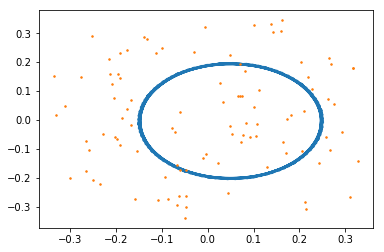

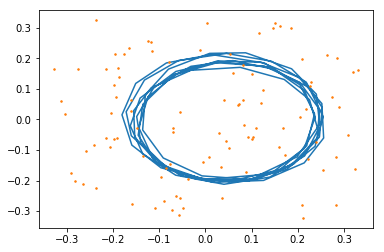

In [10]:
#plt.scatter(initial_position[:,0],initial_position[:,1], s=10)
plt.plot(initial_pose[:,0],initial_pose[:,1], linestyle='-')
plt.plot(initial_landmark[:,0], initial_landmark[:,1], linestyle='None', marker='.', markersize=3)
plt.show()

pts = np.array([rpos for rpos, odm, obs in log])[:,:2]
plt.plot(pts[:,0],pts[:,1], linestyle='-')
plt.plot(landmark[:,0], landmark[:,1], linestyle='None', marker='.', markersize=3)
plt.show()

In [11]:
import chainer
from chainer.utils import type_check

In [12]:
import numpy as np

In [13]:
import chainer
from chainer import function
import chainer.functions as F
import chainer.links as L
from chainer import reporter
from chainer.dataset import convert

In [14]:
import cv2

In [15]:
class PreprocessedDataset(chainer.dataset.DatasetMixin):
    def __init__(self, log_data):
        odm = [odm for rpos, odm, obs in log][1:]
        obs = [obs for rpos, odm, obs in log][1:]
        
        self.idx = np.arange(len(log)-1).astype(np.int32) + 1
        self.odm = np.array(odm).astype(np.float32)
        self.obs = np.array(obs).astype(np.float32)

    def __len__(self):
        return len(self.idx)

    def get_example(self, i):
        return self.idx[i], self.odm[i], self.obs[i]

In [16]:
dataset = PreprocessedDataset(log)

In [17]:
class Net(chainer.Chain):
    def __init__(self, pose, landmark, R, S):
        super(Net, self).__init__()

        self.R = R
        self.S = S
        self.nb_pose = len(pose)
        self.nb_landmark = len(landmark)
            
        with self.init_scope():
            self.pose = L.EmbedID(self.nb_pose, 3, initialW=pose)
            self.landmark = L.EmbedID(self.nb_landmark, 2, initialW=landmark)

    def step(self, pos, odm):
        x, y, r = F.split_axis(pos, (1,2), axis=1)
        u, v = F.split_axis(odm, (1,), axis=1)
        x += u * F.cos(r)
        y += u * F.sin(r)
        r += v
        return F.concat((x, y, r))
        
    def observation(self, pos, lm):
        xy, r = F.split_axis(pos, (2,), axis=1)
        
        nb_pos = len(pos)
        
        _lm = F.reshape(lm, (1, self.nb_landmark, 2))
        _lm = F.broadcast_to(lm, (nb_pos, self.nb_landmark, 2))        
        _xy = F.reshape(xy, (-1, 1, 2))
        _xy = F.broadcast_to(_xy, (nb_pos, self.nb_landmark, 2))
        _r = F.reshape(r, (-1, 1, 1))
        _r = F.broadcast_to(_r, (nb_pos, self.nb_landmark, 1))
        
        d = _lm - _xy
        length = F.sqrt(F.sum(d ** 2, axis=2, keepdims=True))

        dx, dy = F.split_axis(d, (1,), axis=2)
        t = myF.arctan2(dy, dx) - _r
        
        return F.concat((length, t), axis=2)

    def diff_theta(self, d):
        d = F.fmod(d + np.pi, np.array([2*np.pi], dtype=np.float32)) - np.pi
        d = F.fmod(d - np.pi, np.array([2*np.pi], dtype=np.float32)) + np.pi
        return d
    
    def __call__(self, idx, odm, obs):
        xp = self.xp
        
        #
        p0 = self.pose(idx-1)
        p1 = self.step(p0, odm)
        q1 = self.pose(idx)
        r = q1 - p1

        dxy, dr = F.split_axis(r, (2,), axis=1)
        dr = self.diff_theta(dr)
        r = F.concat((dxy, dr), axis=1)
        
        #
        idx = np.arange(self.nb_landmark, dtype=np.int32)        
        lm = self.landmark(idx)
        z = self.observation(q1, lm)
        s = obs - z
        
        dlen, dt = F.split_axis(s, (1,), axis=2)
        dt = self.diff_theta(dt)
        s = F.concat((dlen, dt), axis=2)

        s = F.reshape(s, (-1, 2))
        self.loss = F.sum(F.matmul(r, R)*r) + F.sum(F.matmul(s, S)*s)
        
        return self.loss

In [18]:
R = np.eye(3, dtype=np.float32)
S = np.eye(2, dtype=np.float32)

model =Net(initial_pose, initial_landmark, R, S)
i_array, odm_array, obs_array = convert.concat_examples(dataset[:], -1)
loss = model(i_array, odm_array, obs_array)

In [19]:
print(loss)

variable(264.66766357421875)


In [20]:
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

In [21]:
data_iter = chainer.iterators.SerialIterator(dataset, len(dataset), shuffle=False)
data_count = len(dataset)

sum_loss = 0

while data_iter.epoch < 1000:
    batch = data_iter.next()
    i_array, odm_array, obs_array = convert.concat_examples(batch, -1)
    i = chainer.Variable(i_array)
    odm = chainer.Variable(odm_array)
    obs = chainer.Variable(obs_array)
    
    optimizer.update(model, i, odm, obs)
    sum_loss += float(model.loss.data) * len(y.data)

    if data_iter.is_new_epoch:
        if data_iter.epoch % 100 == 0:
            print('epoch: {}, train mean loss: {}'.format(data_iter.epoch, sum_loss / data_count))
        sum_loss = 0

epoch: 100, train mean loss: 17.591583251953125
epoch: 200, train mean loss: 17.540477752685547
epoch: 300, train mean loss: 17.540504455566406
epoch: 400, train mean loss: 17.540851593017578
epoch: 500, train mean loss: 17.540515899658203
epoch: 600, train mean loss: 17.541471481323242
epoch: 700, train mean loss: 17.540584564208984
epoch: 800, train mean loss: 17.542804718017578
epoch: 900, train mean loss: 17.54275131225586
epoch: 1000, train mean loss: 17.54237937927246


In [22]:
predict_pose = model.pose.W.data
predict_landmark = model.landmark.W.data

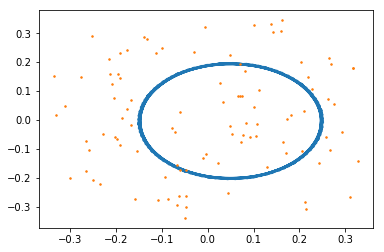

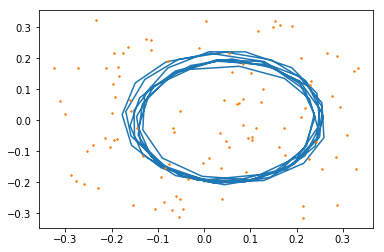

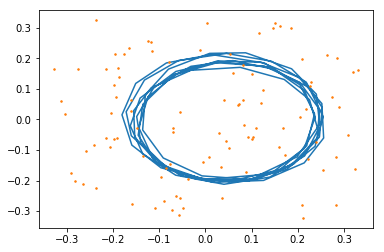

In [23]:
plt.plot(initial_pose[:,0],initial_pose[:,1], linestyle='-')
plt.plot(initial_landmark[:,0], initial_landmark[:,1], linestyle='None', marker='.', markersize=3)
plt.show()

plt.plot(predict_pose[:,0],predict_pose[:,1], linestyle='-')
plt.plot(predict_landmark[:,0], predict_landmark[:,1], linestyle='None', marker='.', markersize=3)
plt.show()

pts = np.array([rpos for rpos, odm, obs in log])[:,:2]
plt.plot(pts[:,0],pts[:,1], linestyle='-')
plt.plot(landmark[:,0], landmark[:,1], linestyle='None', marker='.', markersize=3)
plt.show()